# BP神经网络预测

In [1]:
# 导入包
import torch
from torch import nn
import numpy as np
import torch.nn.functional as Fun
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据

In [2]:
file_name = "data.mat"
data = scio.loadmat(file_name)
x = data.get("PPP")
x = x.T
x = (x-x.mean(0))/x.std(0)
y = data.get("TTT")
y = y[0]


In [3]:
print("x.shape :", x.shape, " y.shape: ", y.shape)

x.shape : (205, 4)  y.shape:  (205,)


In [4]:
def split_train_test(X, y, test_ratio):
    shuffled_indices = np.random.permutation(len(y))
    test_set_size = int(len(y) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return X[train_indices,:], y[train_indices], X[test_indices,:], y[test_indices]

In [5]:
train_x, train_y, test_x, test_y = split_train_test(x, y, 0.2)

In [6]:
train_x.shape, train_y.shape,test_x.shape, test_y.shape

((164, 4), (164,), (41, 4), (41,))

## 将numy转换为tensor

In [7]:
train_x = torch.FloatTensor(train_x)
train_y = torch.FloatTensor(train_y)
test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_iter = torch.utils.data.DataLoader(dataset, 10,shuffle=True)

## 定义BP神经网络

In [8]:
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_features, n_hidden)
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, X_data):
        x = self.hidden(X_data)
        x = Fun.tanh(x)
        predict_y = self.out(x)
        return predict_y

In [9]:
net = Net(4, 9, 1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.025)
loss = torch.nn.MSELoss()
for param in net.parameters():
    torch.nn.init.normal_(param, mean=0, std=0.01)
print(net)

Net(
  (hidden): Linear(in_features=4, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=1, bias=True)
)


In [10]:
train_ls = []
for i in range(1000):
    for x, y in train_iter:
        out = net(x)
        l = loss(out, train_y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    train_ls.append(l)

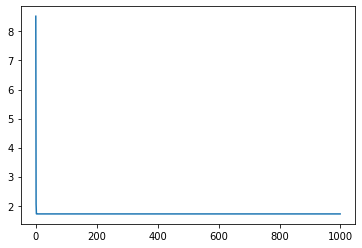

In [11]:
plt.plot(train_ls)
plt.show()

In [12]:
predict_y = net(train_x)
predict_y[0:5]

tensor([[6.0810],
        [6.0812],
        [6.0810],
        [6.0811],
        [6.0811]], grad_fn=<SliceBackward>)

In [13]:
for parameters in net.parameters():
    print(parameters)

Parameter containing:
tensor([[-0.0053, -0.0021,  0.0068,  0.0017],
        [ 0.0039,  0.0109,  0.0047, -0.0005],
        [ 0.0007,  0.0047, -0.0100, -0.0048],
        [-0.0004,  0.0096, -0.0089, -0.0013],
        [ 0.0063,  0.0032,  0.0012,  0.0014],
        [-0.0081,  0.0083, -0.0021,  0.0065],
        [-0.0058,  0.0187, -0.0011, -0.0078],
        [-0.0010, -0.0062, -0.0060,  0.0029],
        [-0.0090,  0.0027,  0.0097,  0.0006]], requires_grad=True)
Parameter containing:
tensor([ 0.4055,  0.4304,  0.3664, -0.6798, -0.0662,  0.0936,  0.1190,  0.4443,
        -0.2703], requires_grad=True)
Parameter containing:
tensor([[ 0.4140,  0.4408,  0.3722, -0.7271, -0.0658,  0.0933,  0.1188,  0.4557,
         -0.2716]], requires_grad=True)
Parameter containing:
tensor([4.8937], requires_grad=True)


In [14]:
# clarke网格误差分析
def clarke(y,y_predicted):
    """
    clarke网格分析

    total, percentage = clarke(y, yp)
    
    INPUTS:
    y       Reference values(血糖浓度参考值)
    yp      Predicted/estimated values(血糖预测值)
    
    OUTPUTS:

    """
    # 设置坐标轴范围和坐标轴名称
    plt.xlim(0, 400*0.0556)
    plt.ylim(0, 400*0.0556)
    plt.xlabel('Reference values of Blood Glucose(mmol/L)')
    plt.ylabel('Predicted values of Blood Glucose(mmol/L)')
    # 获取数据长度
    n = len(y)
    # 散点图绘制数据
    plt.scatter(y, y_predicted, s=15)
    # 绘制网线
    # 上半区网线
    plt.plot([0,400*0.0556],[0,400*0.0556],linestyle=':',c='k') 
    plt.plot([0,175*0.0556/3],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([175*0.0556/3,400*0.0556/1.2],[70*0.0556,400*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,70*0.0556],[84*0.0556,400*0.0556],c='k', linewidth=1)
    plt.plot([0,70*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,290*0.0556],[180*0.0556,400*0.0556],c='k', linewidth=1)
    # 下半区网线绘制
    plt.plot([70*0.0556,70*0.0556],[0,56*0.0556],c='k',linewidth=1)
    plt.plot([70*0.0556,400*0.0556],[56*0.0556,320*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    plt.plot([180*0.0556,400*0.0556],[70*0.0556,70*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,240*0.0556],[70*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([240*0.0556,400*0.0556],[180*0.0556,180*0.0556],c='k',linewidth=1)
    plt.plot([130*0.0556,180*0.0556],[0,70*0.0556],c='k',linewidth=1)
    
    # 绘制区域标签A,B,C,D,E
    plt.text(30*0.0556,20*0.0556,'A',fontsize=9);
    plt.text(30*0.0556,150*0.0556,'D',fontsize=9);
    plt.text(30*0.0556,380*0.0556,'E',fontsize=9);
    plt.text(150*0.0556,380*0.0556,'C',fontsize=9);
    plt.text(160*0.0556,20*0.0556,'C',fontsize=9);
    plt.text(380*0.0556,20*0.0556,'E',fontsize=9);
    plt.text(380*0.0556,120*0.0556,'D',fontsize=9);
    plt.text(380*0.0556,260*0.0556,'B',fontsize=9);
    plt.text(280*0.0556,380*0.0556,'B',fontsize=9);

    # 计算数据
    total = np.zeros(5)
    # A区域
    for i in range(0,n):
        if (y[i] <= 70*0.0556 and y_predicted[i] <= 70*0.0556) or (y_predicted[i] <= 1.2*y[i] and y_predicted[i] >= 0.8*y[i]): 
            total[0] = total[0] + 1
        else:
            # E区域
            if(y[i] >= 180*0.0556 and y_predicted[i] <= 70*0.0556) or (y[i] <= 70*0.0556 and y_predicted[i] >= 180*0.0556):
                total[4] = total[4] + 1
            else:
                # 区域C
                if (y[i] >= 70*0.0556 and y[i] <= 290*0.0556) and (y_predicted[i] >= y[i] + 110*0.0556) or (y[i] >= 130*0.0556 and y[i] <= 180*0.0556) and (y_predicted[i] <= (7/5)*y[i] - 182*0.0556):
                    total[2] = total[2] + 1
                else:
                    # 区域D
                    if (y[i] >= 240*0.0556) and (y_predicted[i] >= 70*0.0556) and (y_predicted[i] <= 180*0.0556) or (y[i] <= 175*0.0556/3 and y_predicted[i] <= 180*0.0556) and (y_predicted[i] >= 70*0.0556) or (y[i] >= 175*0.0556/3 and y[i] <= 70*0.0556) and (y_predicted[i] >= (6/5)*y[i]):
                        total[3] = total[3] + 1
                    else:
                        # 区域B
                        total[1] = total[1] + 1

    percentage = (total/n)*100
    plt.show()
    return total, percentage

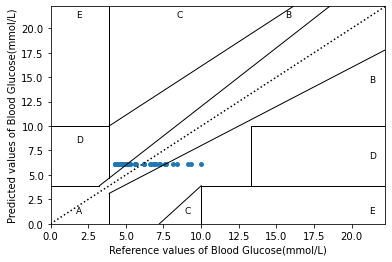

In [15]:
predict_y = net(test_x)
total, percentage = clarke(test_y.detach().numpy(), predict_y.detach().numpy())